# Zebra Page Separation A/B Test Analysis Report 3: 
# Usage of ToC
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__

July 2023

## TICKETS:
Instumentation planning : 
- Spec: [T333222](https://phabricator.wikimedia.org/T333222)

Instrumentation deployment :  
- Launch AB test: [T335972](https://phabricator.wikimedia.org/T335972)
- Fix bug: [T336969](https://phabricator.wikimedia.org/T336969) [T337955](https://phabricator.wikimedia.org/T337955)

Data tickets:
- Data QA: [T336299](https://phabricator.wikimedia.org/T336299)
- __Analysis: [T335379](https://phabricator.wikimedia.org/T335379)__


#  Curiosity Question1: Does it impact the usage of TOC as the new layout separated ToC and content into different boxes?					

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [3]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Importing data

In [9]:
df_pageviews <- read.csv("Data/pageviews_20230710.csv")

In [10]:
summary(df_pageviews)

  session_id         page_token            wiki           editcountbucket   
 Length:19921367    Length:19921367    Length:19921367    Length:19921367   
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  test_group             pvs   
 Length:19921367    Min.   :1  
 Class :character   1st Qu.:1  
 Mode  :character   Median :1  
                    Mean   :1  
                    3rd Qu.:1  
                    Max.   :3  

In [11]:
query_click_toc <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE  t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_anon
AND NOT is_bot
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT t3.event.token AS session_id, 
wiki, event.isanon,  t4.test_group, event.name, t3.event.editCountBucket, t3.event.pageToken,  count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND event.name IN (  'ui.sidebar-toc' , 'toc-heading.toc-pinned-disabled', 'toc-heading.toc-pinned-enabled')
AND event.action='click' AND event.skinversion=2 
-- exclude anonymous users, some sessions swtich between loggin mode and loggout mode.
AND NOT event.isanon
GROUP BY t3.event.token, t3.wiki, event.isanon, t4.test_group, event.name, t3.event.editCountBucket, t3.event.pageToken
"

In [6]:
#df_toc <-  read.csv('Data/click_toc_20230622.csv')

In [12]:
df_toc <- wmfdata::query_hive(query_click_toc)

Don't forget to authenticate with Kerberos using kinit



In [14]:
summary(df_toc)

  session_id            wiki              isanon           test_group       
 Length:688881      Length:688881      Length:688881      Length:688881     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     name           editcountbucket     pagetoken             clicks       
 Length:688881      Length:688881      Length:688881      Min.   :  1.000  
 Class :character   Class :character   Class :character   1st Qu.:  1.000  
 Mode  :character   Mode  :character   Mode  :character   Median :  1.000  
                                                          Mean   :  1.644  
                                                          3rd Qu.:  2.000  
     

In [15]:
df_toc_aggr <- df_toc %>%
  group_by(session_id,wiki,test_group,pagetoken, editcountbucket) %>%
  summarize(cnt_clicks=sum(clicks),.groups='drop')

In [17]:
summary(df_toc_aggr)

  session_id            wiki            test_group         pagetoken        
 Length:688716      Length:688716      Length:688716      Length:688716     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 editcountbucket      cnt_clicks     
 Length:688716      Min.   :  1.000  
 Class :character   1st Qu.:  1.000  
 Mode  :character   Median :  1.000  
                    Mean   :  1.644  
                    3rd Qu.:  2.000  
                    Max.   :294.000  

In [18]:
df_toc_pv <- merge( df_pageviews,df_toc_aggr ,by.x=c("session_id","page_token","wiki","test_group","editcountbucket"), by.y=c("session_id","pagetoken","wiki","test_group","editcountbucket"),all.x=TRUE )

In [19]:
summary(df_toc_pv)

  session_id         page_token            wiki            test_group       
 Length:19921367    Length:19921367    Length:19921367    Length:19921367   
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
 editcountbucket         pvs      cnt_clicks      
 Length:19921367    Min.   :1   Min.   :  1       
 Class :character   1st Qu.:1   1st Qu.:  1       
 Mode  :character   Median :1   Median :  1       
                    Mean   :1   Mean   :  2       
                    3rd Qu.:1   3rd Qu.:  2       
                    Max.   :3   Max.   :294       
                           

In [22]:
df_toc_pv[is.na(df_toc_pv)] <- 0

In [23]:
df_toc_pv_per_session  <- df_toc_pv %>% 
   group_by(session_id, wiki,test_group, editcountbucket) %>%
   summarize(n_pvs=sum(pvs), n_pages=n_distinct(page_token), n_clicks=sum(cnt_clicks), .groups='drop')

In [25]:
summary(df_toc_pv_per_session)

  session_id            wiki            test_group        editcountbucket   
 Length:1129321     Length:1129321     Length:1129321     Length:1129321    
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     n_pvs             n_pages            n_clicks       
 Min.   :    1.00   Min.   :    1.00   Min.   :   0.000  
 1st Qu.:    1.00   1st Qu.:    1.00   1st Qu.:   0.000  
 Median :    4.00   Median :    4.00   Median :   0.000  
 Mean   :   17.64   Mean   :   17.64   Mean   :   0.978  
 3rd Qu.:   11.00   3rd Qu.:   11.00   3rd Qu.:   0.000  
 Max.   :31002.00   Max.   :31002.00   Max.   :6520.000  

# Data exploration

Warning message:
“Removed 5510 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


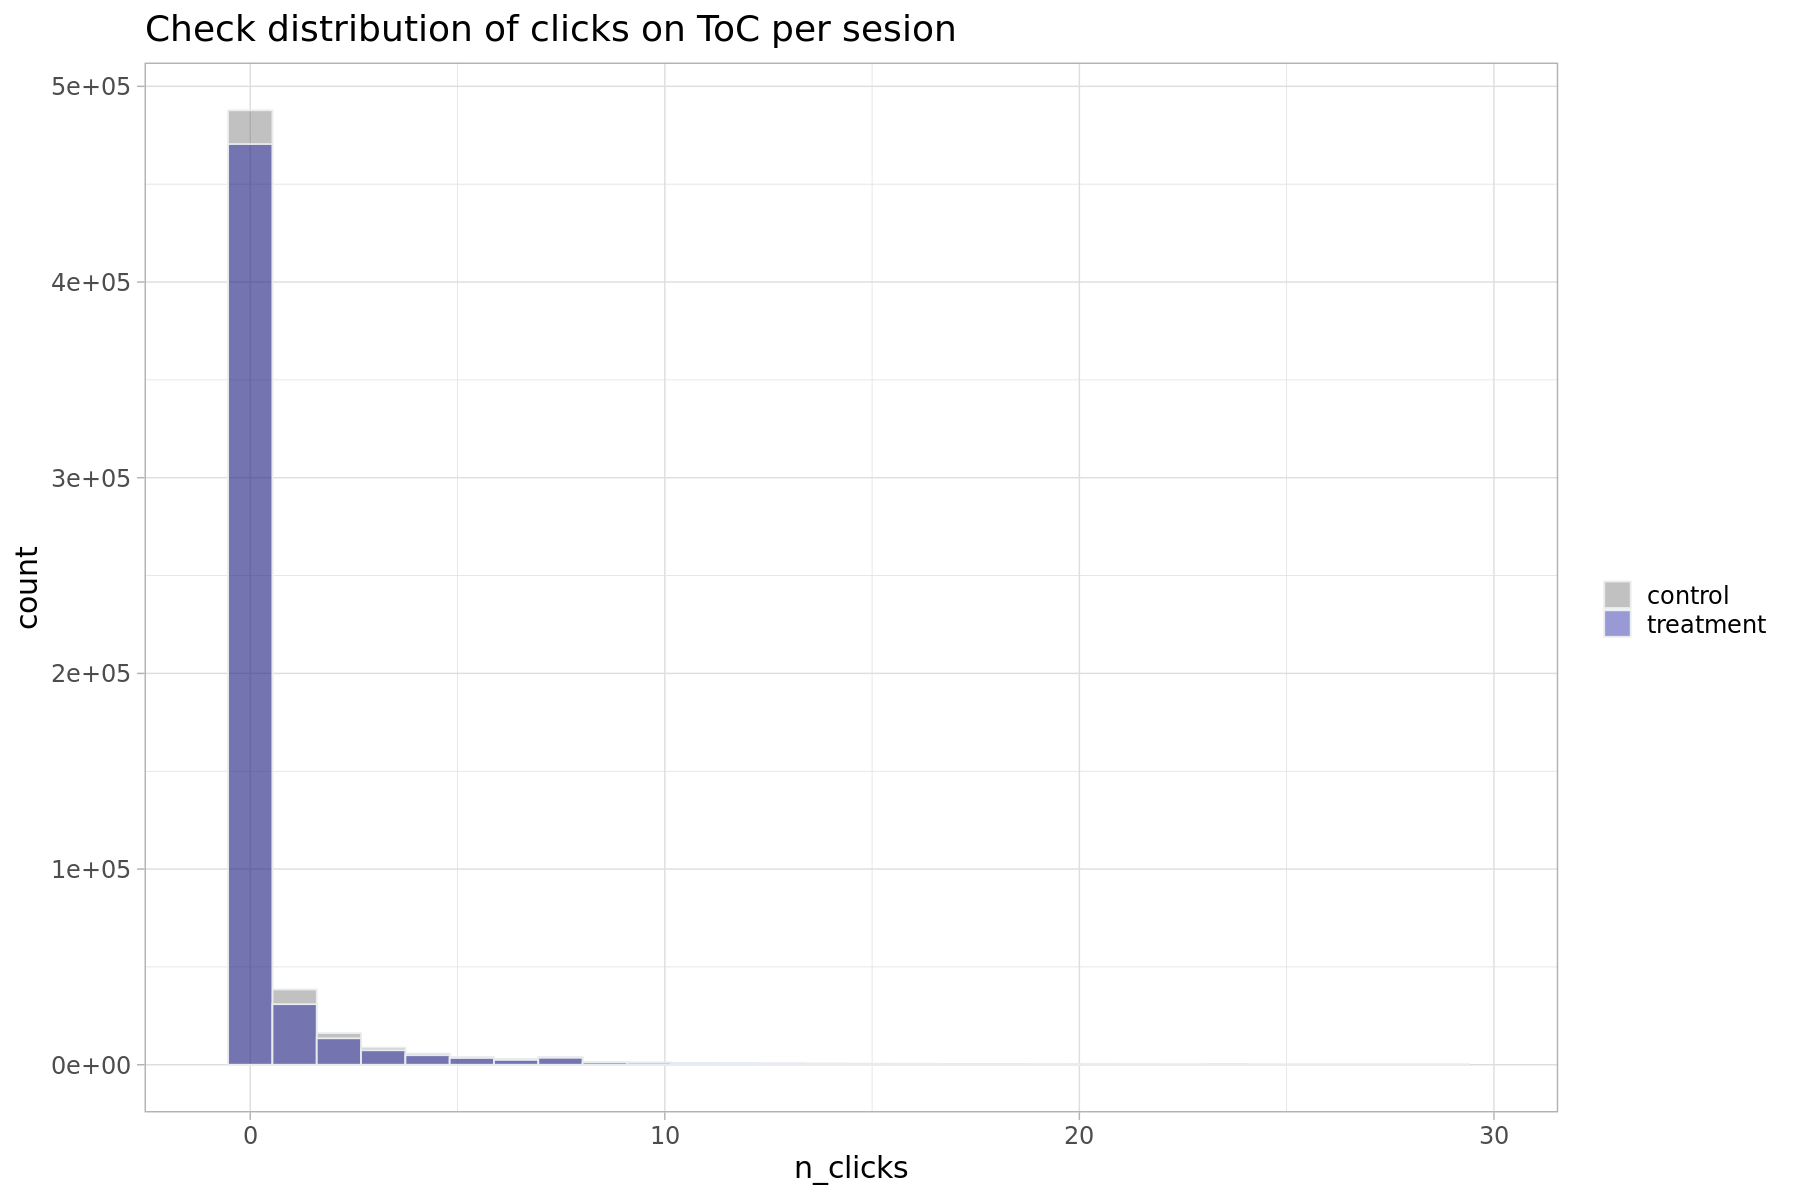

In [75]:
p1 <- df_toc_pv_per_session %>%
  #filter(edit_attempts<30) %>%
  ggplot( aes(x=n_clicks, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
   scale_x_continuous(limits = c(-1,30)) +
    #scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of clicks on ToC per sesion",
         fill="") +
    theme_light(base_size=18)
p1

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 958275 rows containing non-finite values (`stat_bin()`).”


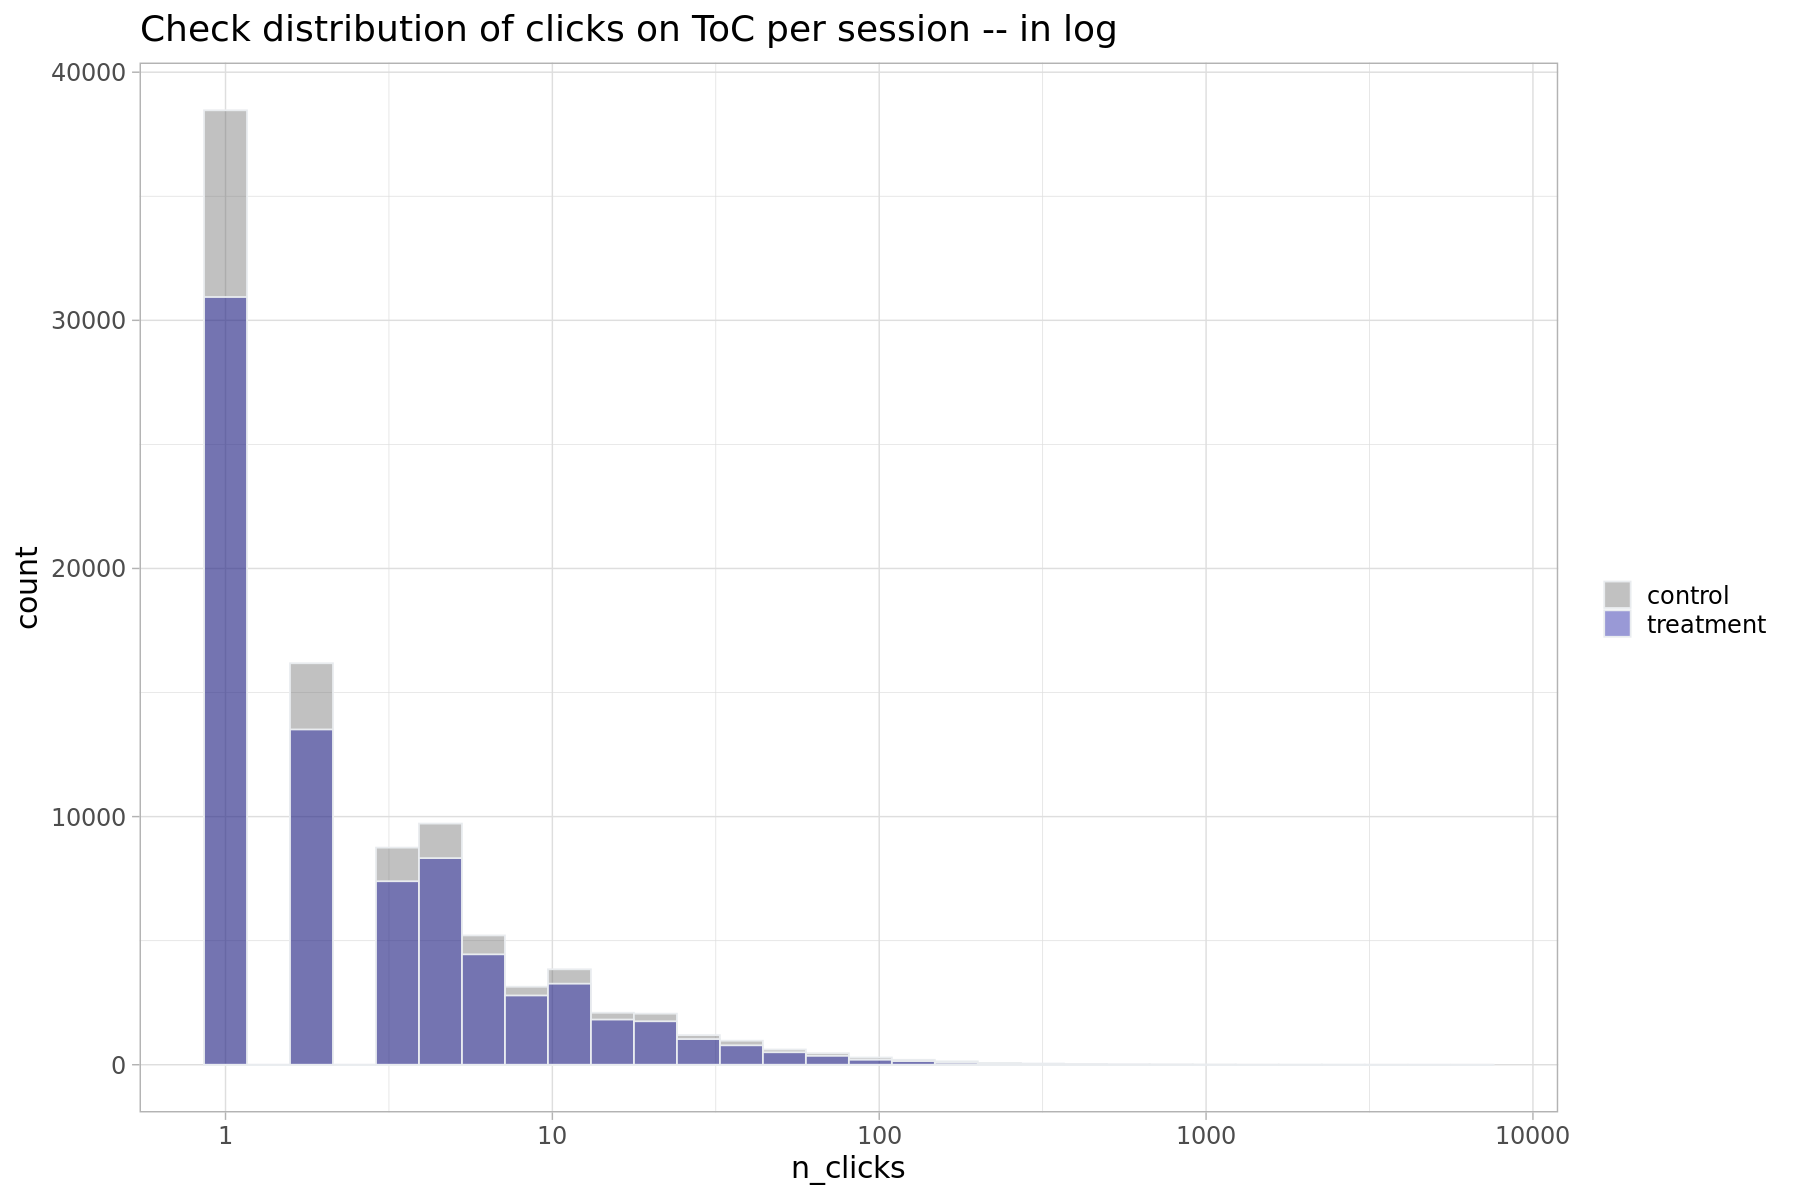

In [76]:
p1 <- df_toc_pv_per_session %>%
  ggplot( aes(x=n_clicks, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
   scale_x_continuous(limits = c(-1,30)) +
    scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of clicks on ToC per session -- in log ",
         fill="") +
    theme_light(base_size=18)
p1

Warning message:
“Removed 5510 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


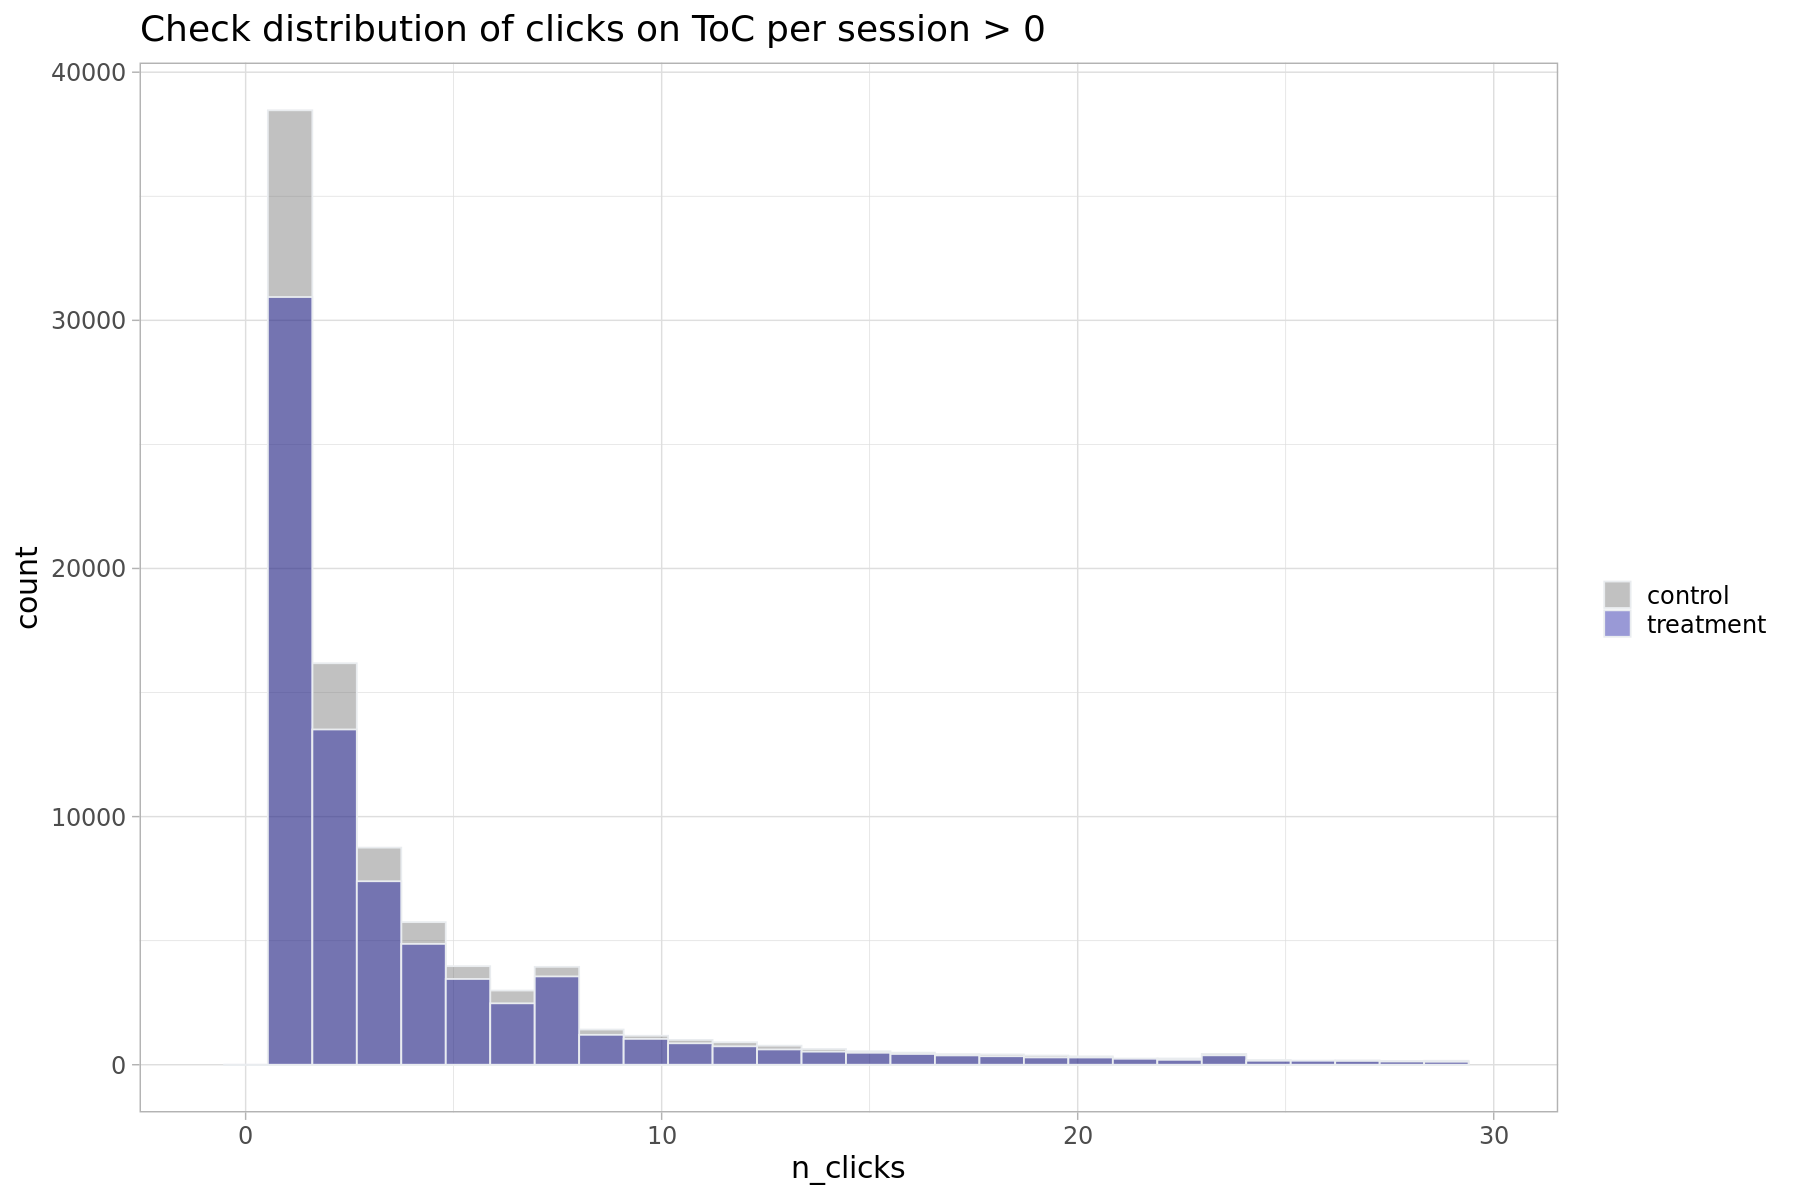

In [78]:
p1 <- df_toc_pv_per_session %>%
  filter(n_clicks>0) %>%
  ggplot( aes(x=n_clicks, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
   scale_x_continuous(limits = c(-1,30)) +
    #scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of clicks on ToC per session > 0",
         fill="") +
    theme_light(base_size=18)
p1

In [79]:
df_toc_pv_per_session %>%  
 filter(n_clicks==0) %>%
 nrow()


[1] 958275

In [80]:
df_toc_pv_per_session %>%  
 nrow()

[1] 1129321

In [81]:
df_toc_pv_per_session %>%  
 filter(n_clicks>0) %>%
 nrow()

[1] 171046

In [82]:
958275/1129321

[1] 0.8485408

#### Note

Data is zero inflated. 84.85% sessions did not click on ToC.

The data without 0 is in possion distribition or negative binomial distribution.

# Analysis
## By wiki

In [35]:
df_toc_click_pv_wiki <- df_toc_pv_per_session %>% 
  group_by( wiki ,test_group) %>%
  summarize(total_pvs=sum(n_pvs), total_pv_pages=sum(n_pages),
            total_toc_clicks=sum(n_clicks),
            n_sessions=n_distinct(session_id), ,.groups='drop')  %>%
  mutate( toc_clicks_per_session =round( total_toc_clicks/n_sessions,4) ,
        toc_clicks_per_pv=round(total_toc_clicks/total_pvs,4)
         )

In [36]:
df_toc_click_pv_wiki

wiki,test_group,total_pvs,total_pv_pages,total_toc_clicks,n_sessions,toc_clicks_per_session,toc_clicks_per_pv
<chr>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
enwiki,control,8032826,8031653,530053,451785,1.1732,0.0660
enwiki,treatment,7975065,7974056,438753,422227,1.0391,0.0550
fawiki,control,156055,155993,3883,9573,0.4056,0.0249
fawiki,treatment,125034,125000,1490,8954,0.1664,0.0119
frwiki,control,953480,953377,51825,55295,0.9372,0.0544
frwiki,treatment,925160,925046,29445,52465,0.5612,0.0318
hewiki,control,188825,188803,6318,9136,0.6915,0.0335
hewiki,treatment,195126,195085,3601,9777,0.3683,0.0185
kowiki,control,98851,98850,1591,4728,0.3365,0.0161


In [37]:
df_toc_click_pv_wiki %>%
   group_by(test_group) %>%
   summarize(all_toc_clicks=sum(total_toc_clicks), all_pvs=sum(total_pvs), all_sessions=sum(n_sessions) , .groups='drop') %>%
   mutate( toc_click_per_session =round( all_toc_clicks/all_sessions,4) ,
        toc_click_per_pv=round(all_toc_clicks/all_pvs,4) )

test_group,all_toc_clicks,all_pvs,all_sessions,toc_click_per_session,toc_click_per_pv
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
control,610246,10056089,569972,1.0707,0.0607
treatment,493722,9868007,536839,0.9197,0.0500


In [32]:
0.9197/1.0707-1

[1] -0.1410292

In [33]:
0.0500/0.0607 -1 

[1] -0.1762768

### Note
- We observed an overall 14.1% decrease in the ToC clicks per session (control 1.0707 ; treatment 0.9197, shown in below table) from the users who were shown the new page separation across all participating Wikipedias and all editor experience levels.
- We observed a 17.6% decrease in ToC click rate (control 0.0607 ; treatment 0.0500, shown in below table) from the users who were shown the new page separation across all participating Wikipedias and all editor experience levels.

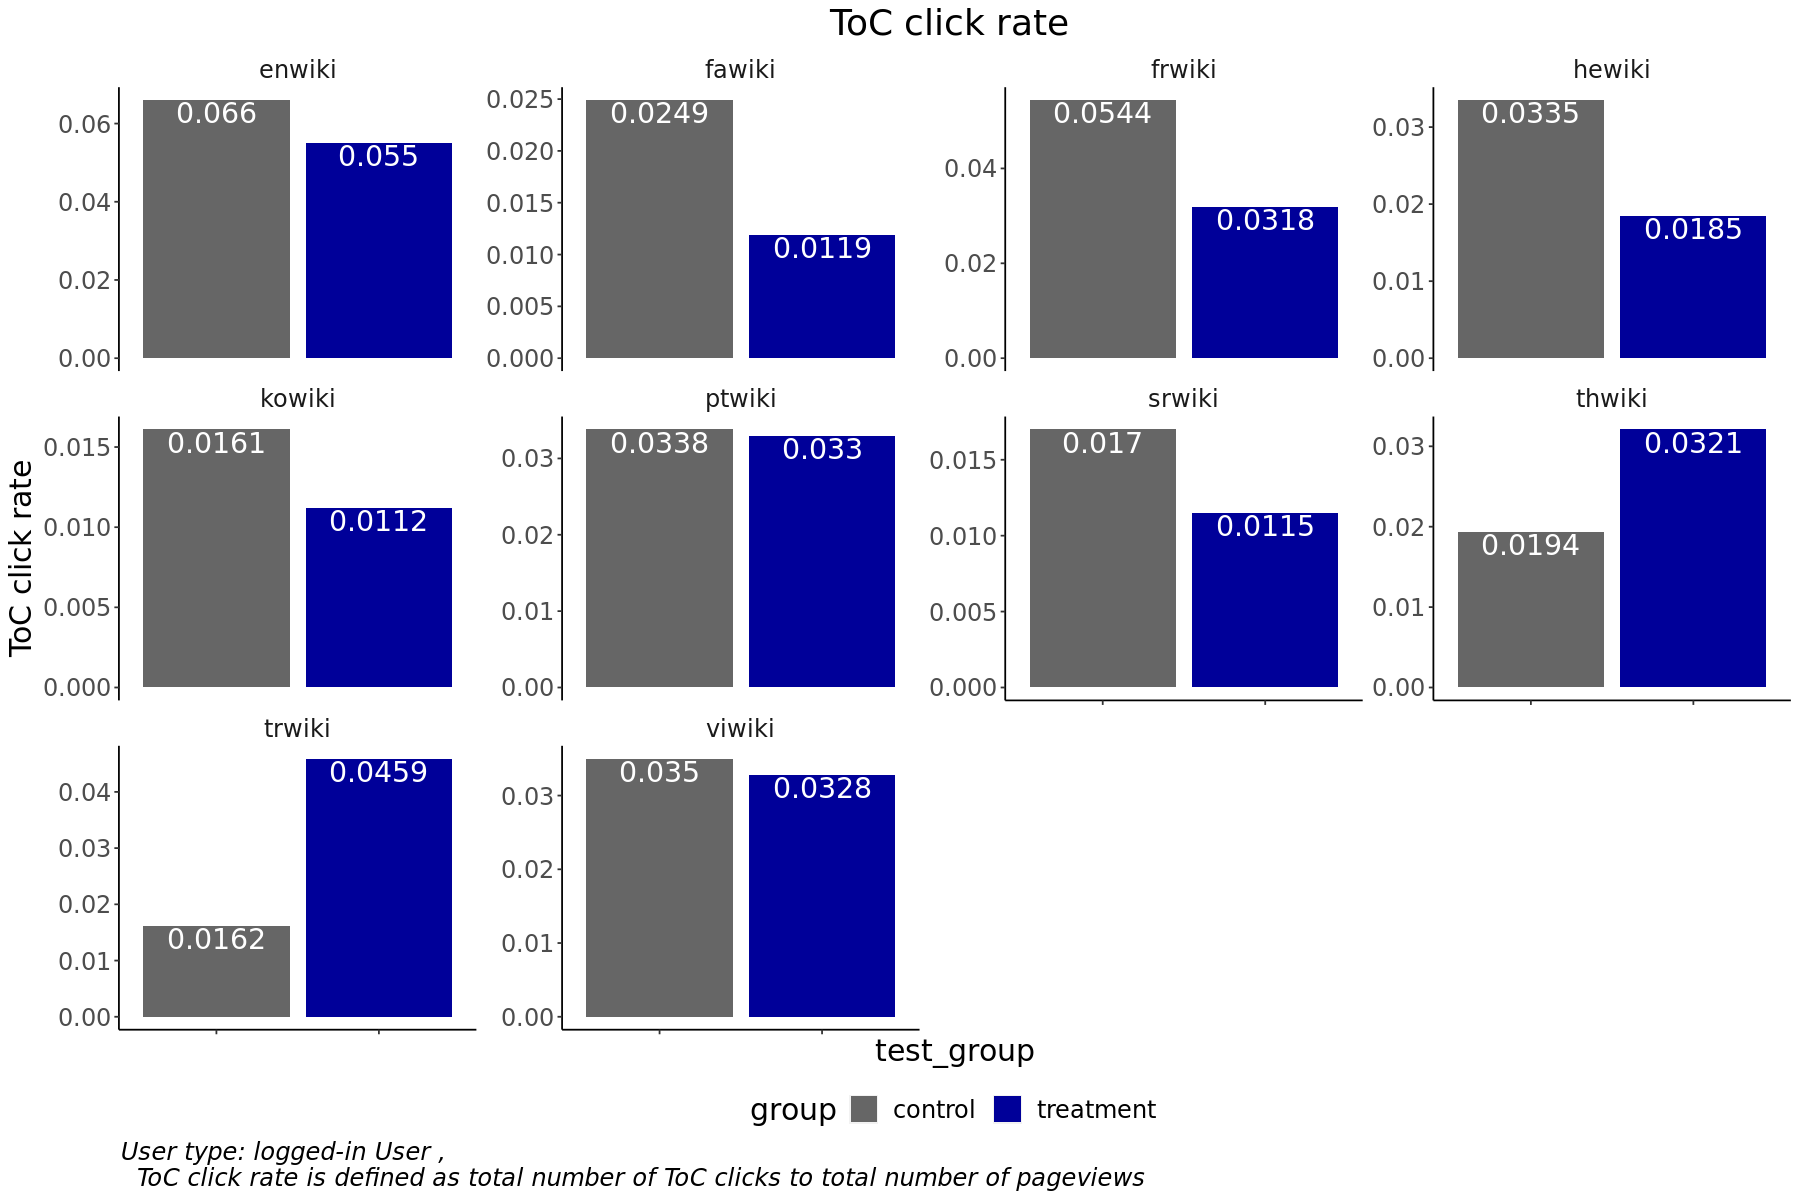

In [109]:
barchart_toc_per_pv  <- df_toc_click_pv_wiki  %>%
        select(wiki, test_group, toc_clicks_per_pv) %>%
        ggplot(aes(x = test_group, y= toc_clicks_per_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(toc_clicks_per_pv)), color = "white", position = position_dodge(width = 1), 
                  vjust =1.1, hjust = 0.5, size = 6) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "ToC click rate" ,
             title = "ToC click rate " ,
             caption = "User type: logged-in User ,
  ToC click rate is defined as total number of ToC clicks to total number of pageviews" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_toc_per_pv

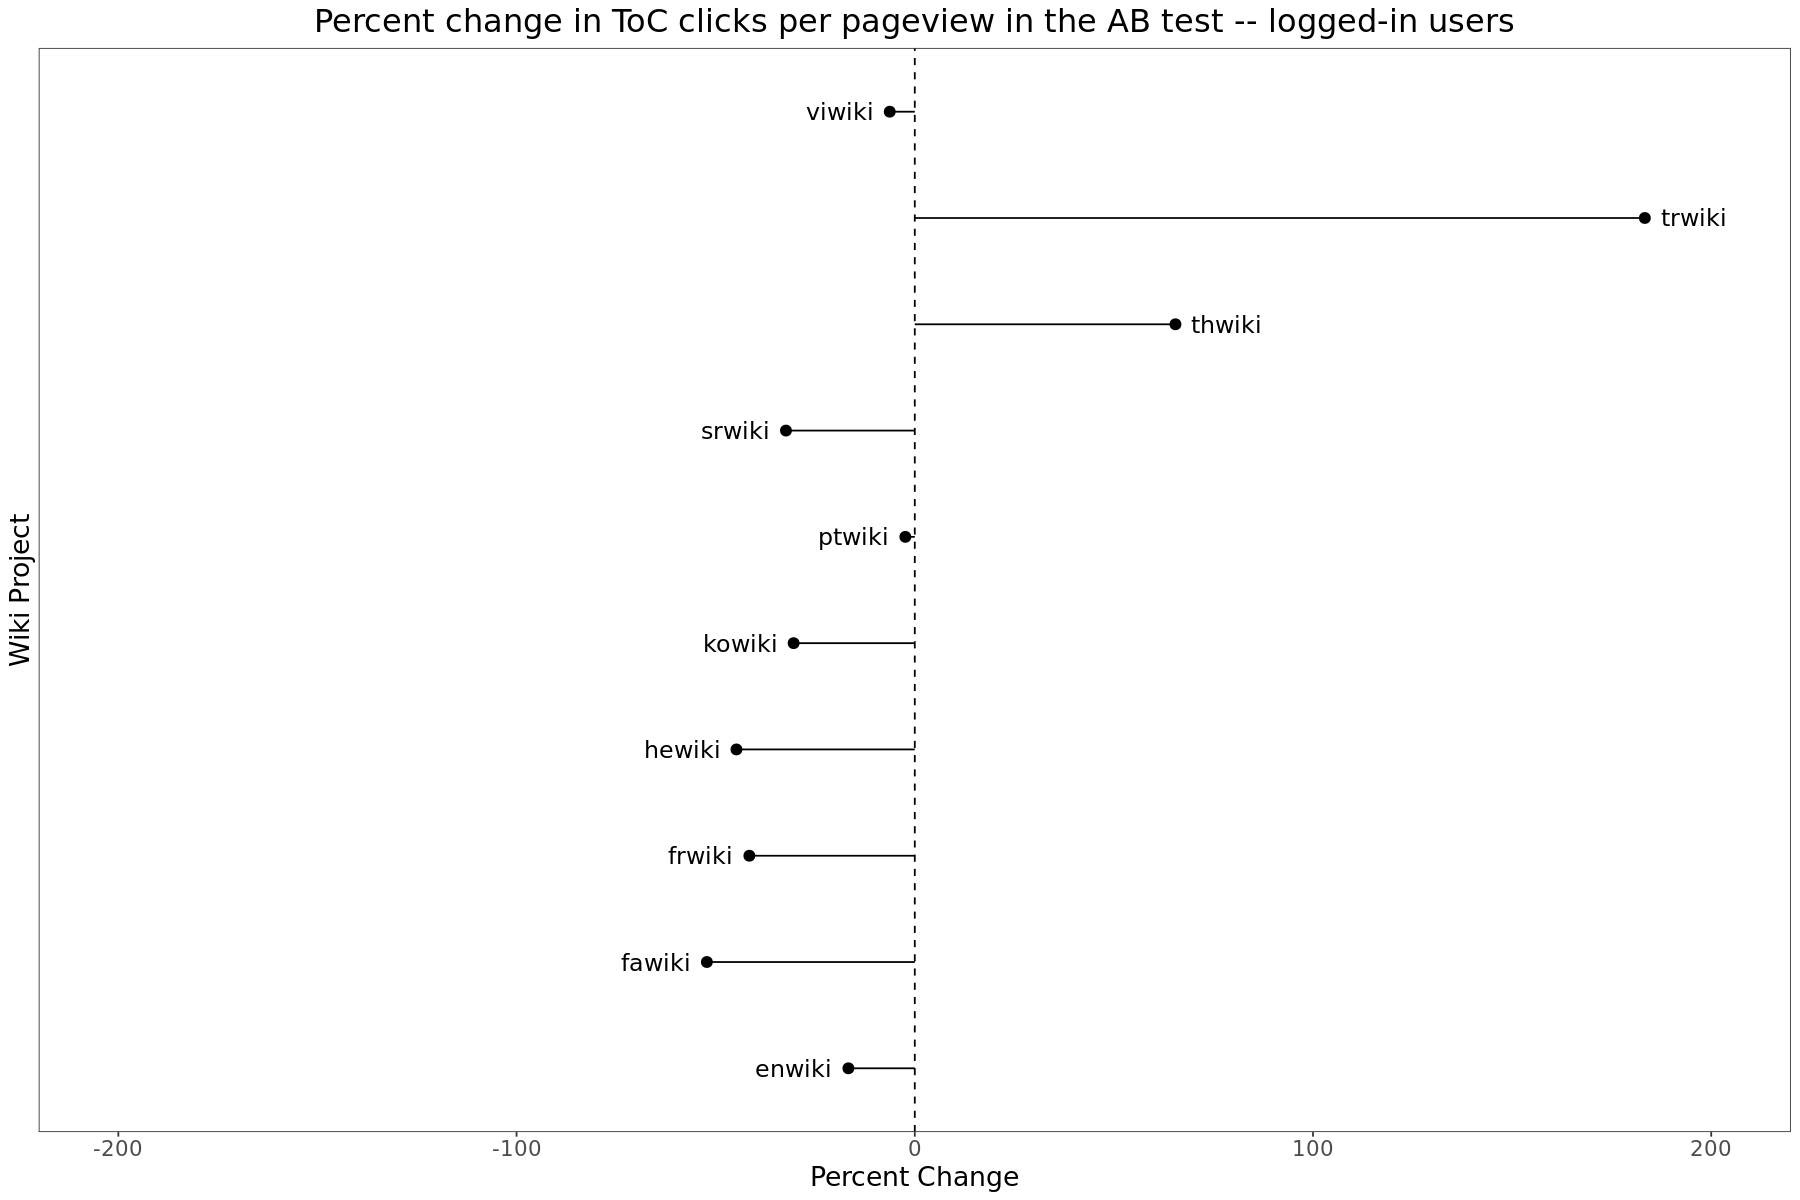

In [112]:
pct_g <- df_toc_click_pv_wiki  %>%
        select(wiki, test_group, toc_clicks_per_pv) %>%
        spread(test_group, toc_clicks_per_pv) %>%
        mutate(
            pct_change = round((treatment-control)/control * 100 , 2)
        ) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-200, 200)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in ToC clicks per pageview in the AB test -- logged-in users") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

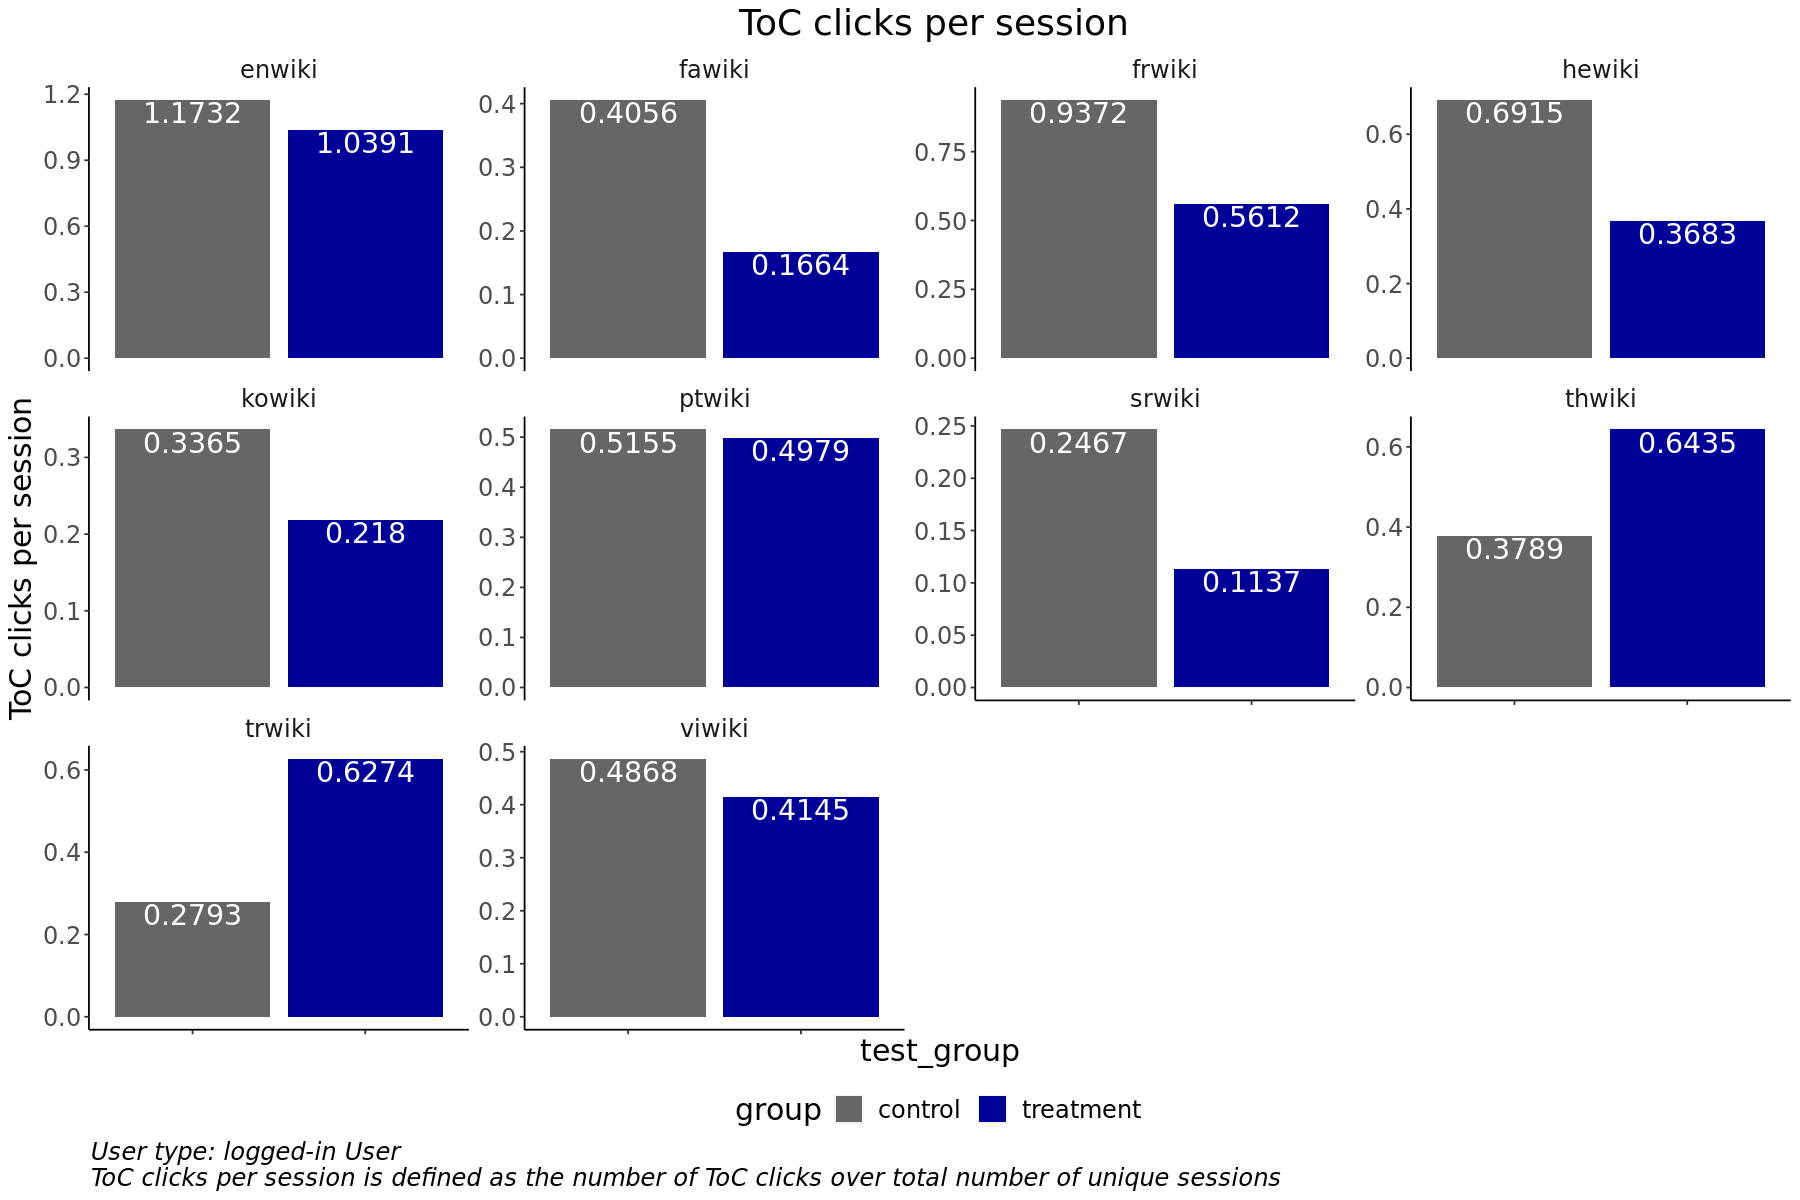

In [114]:
barchart_toc_per_session  <- df_toc_click_pv_wiki  %>%
        select(wiki, test_group, toc_clicks_per_session) %>%
        ggplot(aes(x = test_group, y= toc_clicks_per_session, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(toc_clicks_per_session)), color = "white", position = position_dodge(width = 1), 
                  vjust =1.1, hjust = 0.5, size = 6) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "ToC clicks per session" ,
             title = "ToC clicks per session " ,
             caption = "User type: logged-in User 
ToC clicks per session is defined as the number of ToC clicks over total number of unique sessions" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_toc_per_session

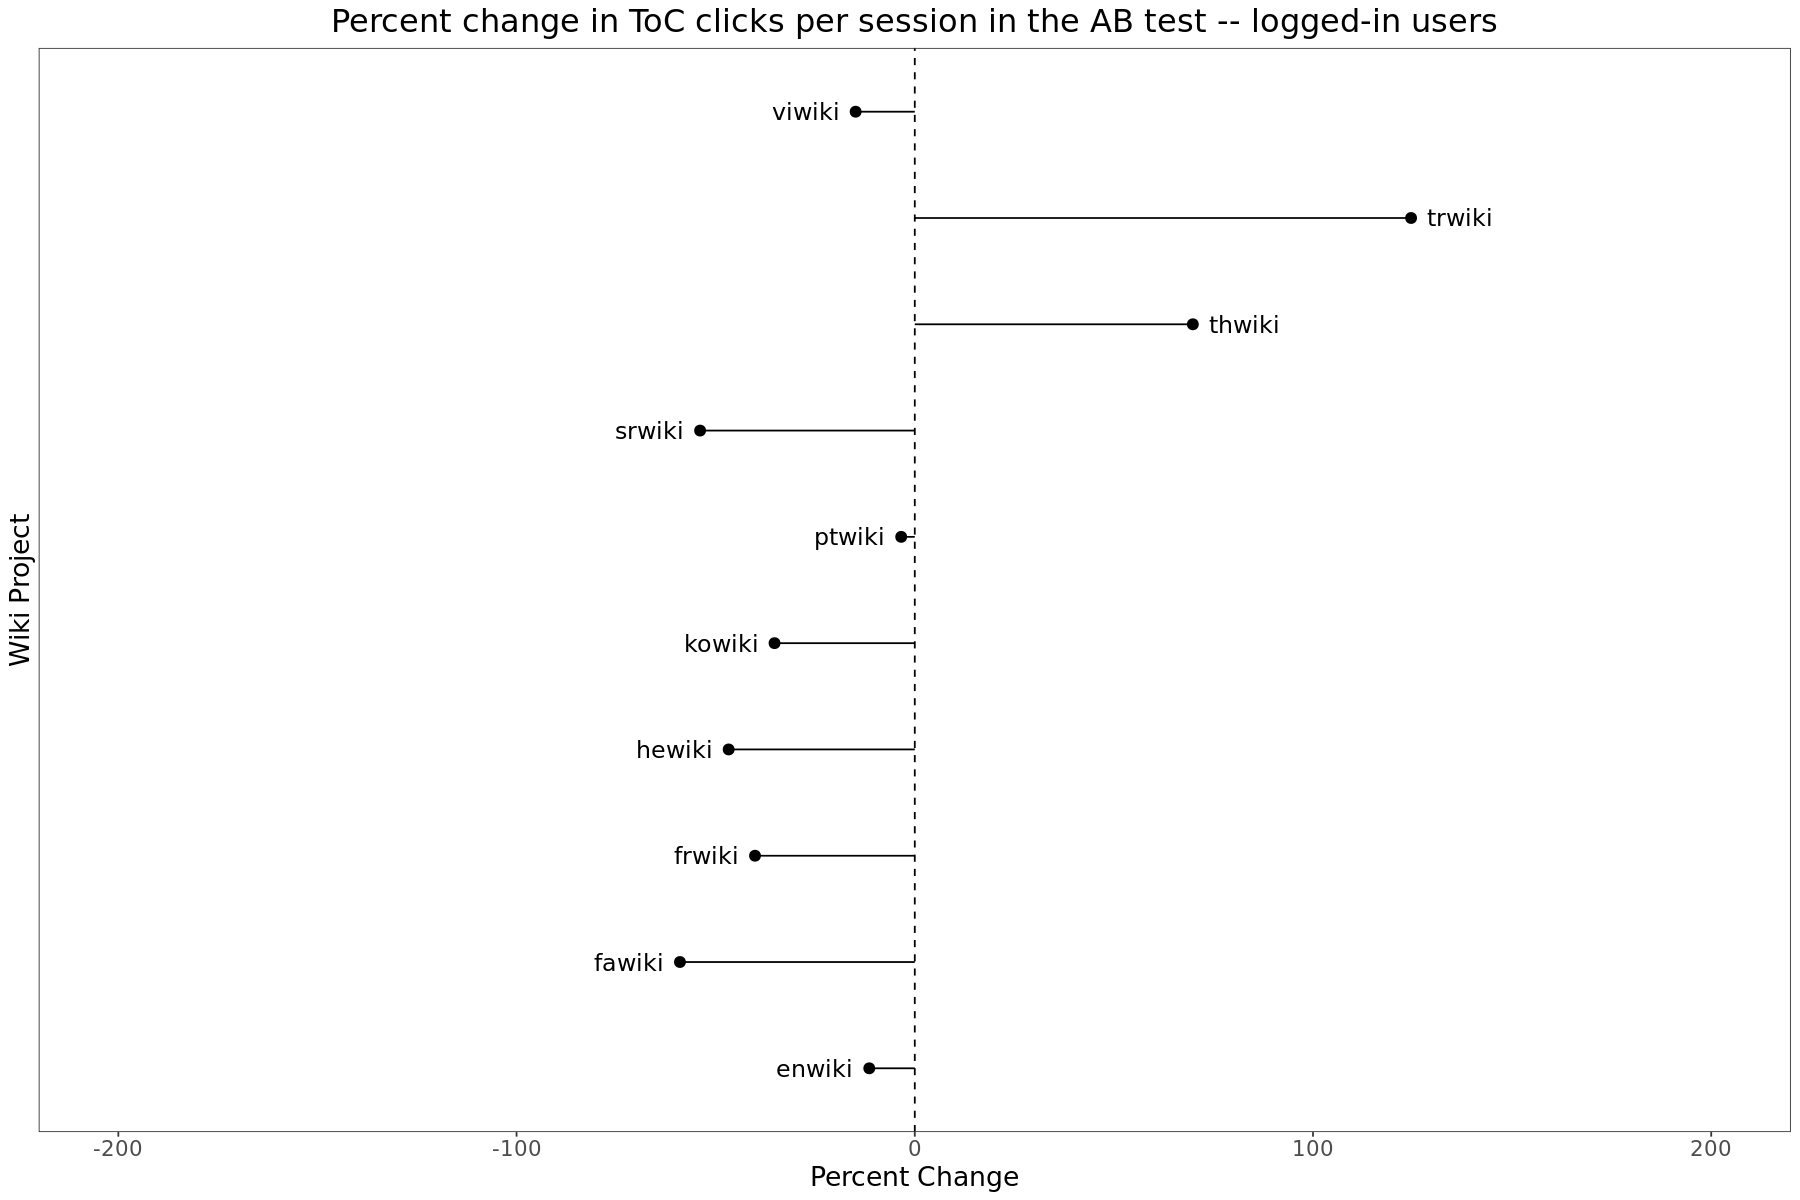

In [115]:
pct_g <- df_toc_click_pv_wiki  %>%
        select(wiki, test_group, toc_clicks_per_session) %>%
        spread(test_group, toc_clicks_per_session) %>%
        mutate(
            pct_change = round((treatment-control)/control * 100 , 2)
        ) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-200, 200)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in ToC clicks per session in the AB test -- logged-in users") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

### Note

When broken down by wiki, 8 out of 10 wikis have exhibited a decrease.


## By edit bucket

In [119]:
df_toc_pvs_bucket_per_session <- df_toc_pv  %>% 
  mutate(
          editcountbucket_n = 
            case_when(
                editcountbucket == '0 edits' ~ 0 ,
                editcountbucket == '1-4 edits' ~ 4,
                editcountbucket == '5-99 edits' ~ 99,
                editcountbucket == '100-999 edits'  ~ 999,
                editcountbucket == '1000+ edits' ~ 1000,
                TRUE ~ NA
            )
        ) %>%
   group_by(session_id, wiki, test_group ) %>%
   summarize(sum_pvs=sum(pvs), sum_pv_pages=n_distinct(page_token),
             sum_toc_clicks=sum(cnt_clicks), 
             editcountbucket_begin=min(editcountbucket_n),
             editcountbucket_end=max(editcountbucket_n),
             .groups='drop')

In [120]:
df_toc_pvs_bucket_per_session <- df_toc_pvs_bucket_per_session %>%
     mutate(
          editcountbucket_lab = factor(
            case_when(
                editcountbucket_begin == 0 ~ '0_edits'  ,
                editcountbucket_begin == 4 ~ '1_4_edits' ,
                editcountbucket_begin == 99 ~ '5_99_edits' ,
                editcountbucket_begin == 999 ~ '100_999_edits'  ,
                editcountbucket_begin == 1000 ~ '1000_more_edits',
                TRUE ~ 'others'
            ), levels = c('0_edits', '1_4_edits' ,'5_99_edits', '100_999_edits', '1000_more_edits', 'other')
          ) 
         )


In [121]:
df_toc_click_editbucket_overall <- df_toc_pvs_bucket_per_session %>%
   group_by(test_group, editcountbucket_lab ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(sum_pv_pages), n_sessions=n_distinct(session_id), 
             total_toc_clicks=sum(sum_toc_clicks),
             .groups='drop') %>%
   mutate( toc_click_per_session =round( total_toc_clicks/n_sessions,4) ,
           toc_click_per_pv =round( total_toc_clicks/total_pvs,4)
            )
  

In [122]:
df_toc_click_editbucket_overall

test_group,editcountbucket_lab,total_pvs,total_pv_pages,n_sessions,total_toc_clicks,toc_click_per_session,toc_click_per_pv
<chr>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
control,0_edits,1675249,1674933,186627,98955,0.5302,0.0591
control,1_4_edits,828957,828788,74938,65549,0.8747,0.0791
control,5_99_edits,2253880,2253578,150087,182406,1.2153,0.0809
control,100_999_edits,1686450,1686178,77818,121488,1.5612,0.0720
control,1000_more_edits,3611553,3611155,80502,141848,1.7620,0.0393
treatment,0_edits,1551263,1550968,153733,85655,0.5572,0.0552
treatment,1_4_edits,822927,822811,73213,52637,0.7190,0.0640
treatment,5_99_edits,2207717,2207439,152687,147653,0.9670,0.0669
treatment,100_999_edits,1750183,1749961,80104,95258,1.1892,0.0544


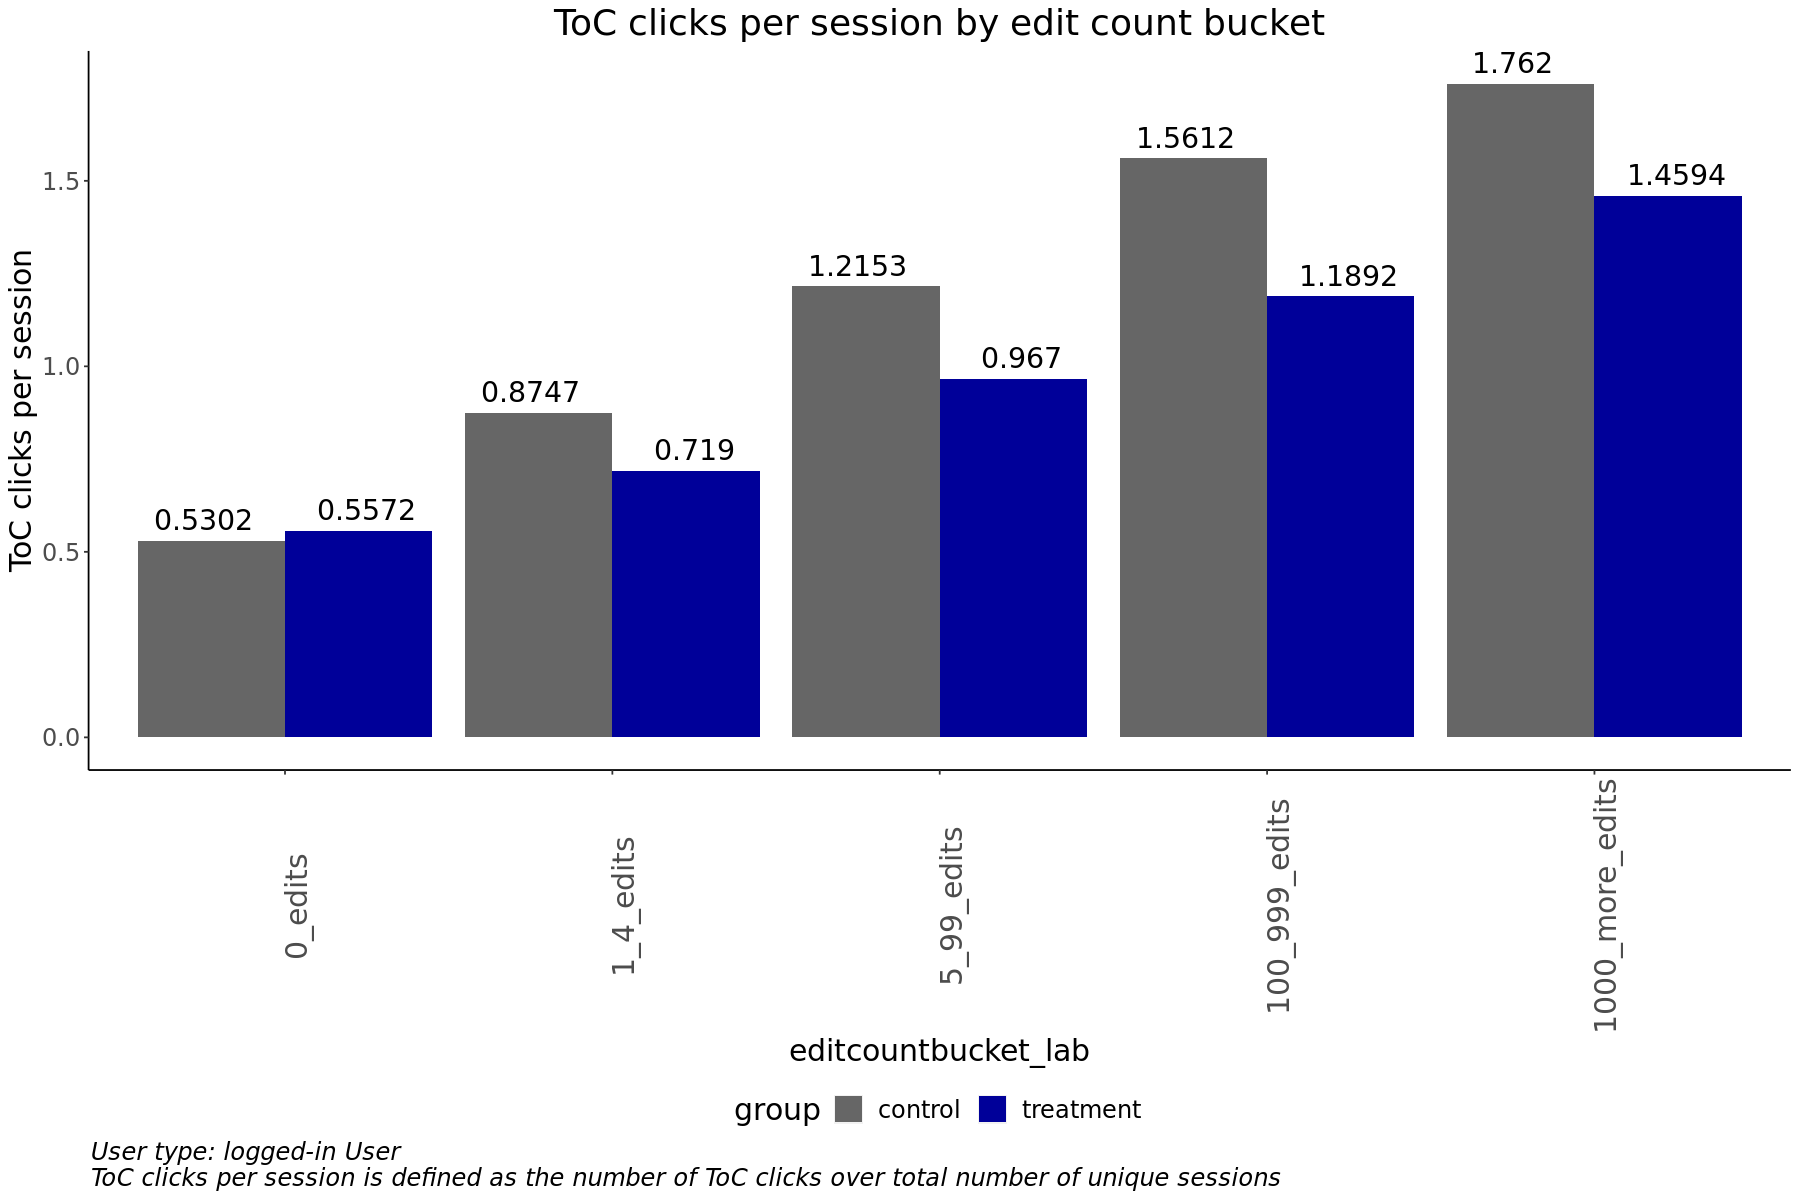

In [126]:
barchart_toc_click_editcountbucket_overall  <- df_toc_click_editbucket_overall  %>%
        ggplot(aes(x = editcountbucket_lab, y= toc_click_per_session, fill=test_group)) +
        geom_text(aes(label = paste(toc_click_per_session)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.5, hjust = 0.5, size = 6) +
        geom_bar(stat="identity", position = 'dodge') +
        labs (
              y = "ToC clicks per session" ,
             title = "ToC clicks per session by edit count bucket" ,
             caption = "User type: logged-in User
ToC clicks per session is defined as the number of ToC clicks over total number of unique sessions" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_toc_click_editcountbucket_overall

Cross check with pre-join data : pass

In [129]:
df_toc %>% 
   group_by(editcountbucket,test_group) %>%
    summarize(all_toc_clicks=sum(clicks),  all_sessions=n_distinct(session_id) , .groups='drop') %>%
   mutate( 
   click_per_session=round(all_toc_clicks/all_sessions,4)
   )

editcountbucket,test_group,all_toc_clicks,all_sessions,click_per_session
<chr>,<chr>,<int>,<int>,<dbl>
0 edits,control,94055,19772,4.7570
0 edits,treatment,84475,15676,5.3888
1-4 edits,control,71390,13885,5.1415
1-4 edits,treatment,54664,10658,5.1289
100-999 edits,control,125997,16996,7.4133
100-999 edits,treatment,97565,14576,6.6935
1000+ edits,control,144364,18234,7.9173
1000+ edits,treatment,114428,15419,7.4212
5-99 edits,control,190671,29955,6.3652


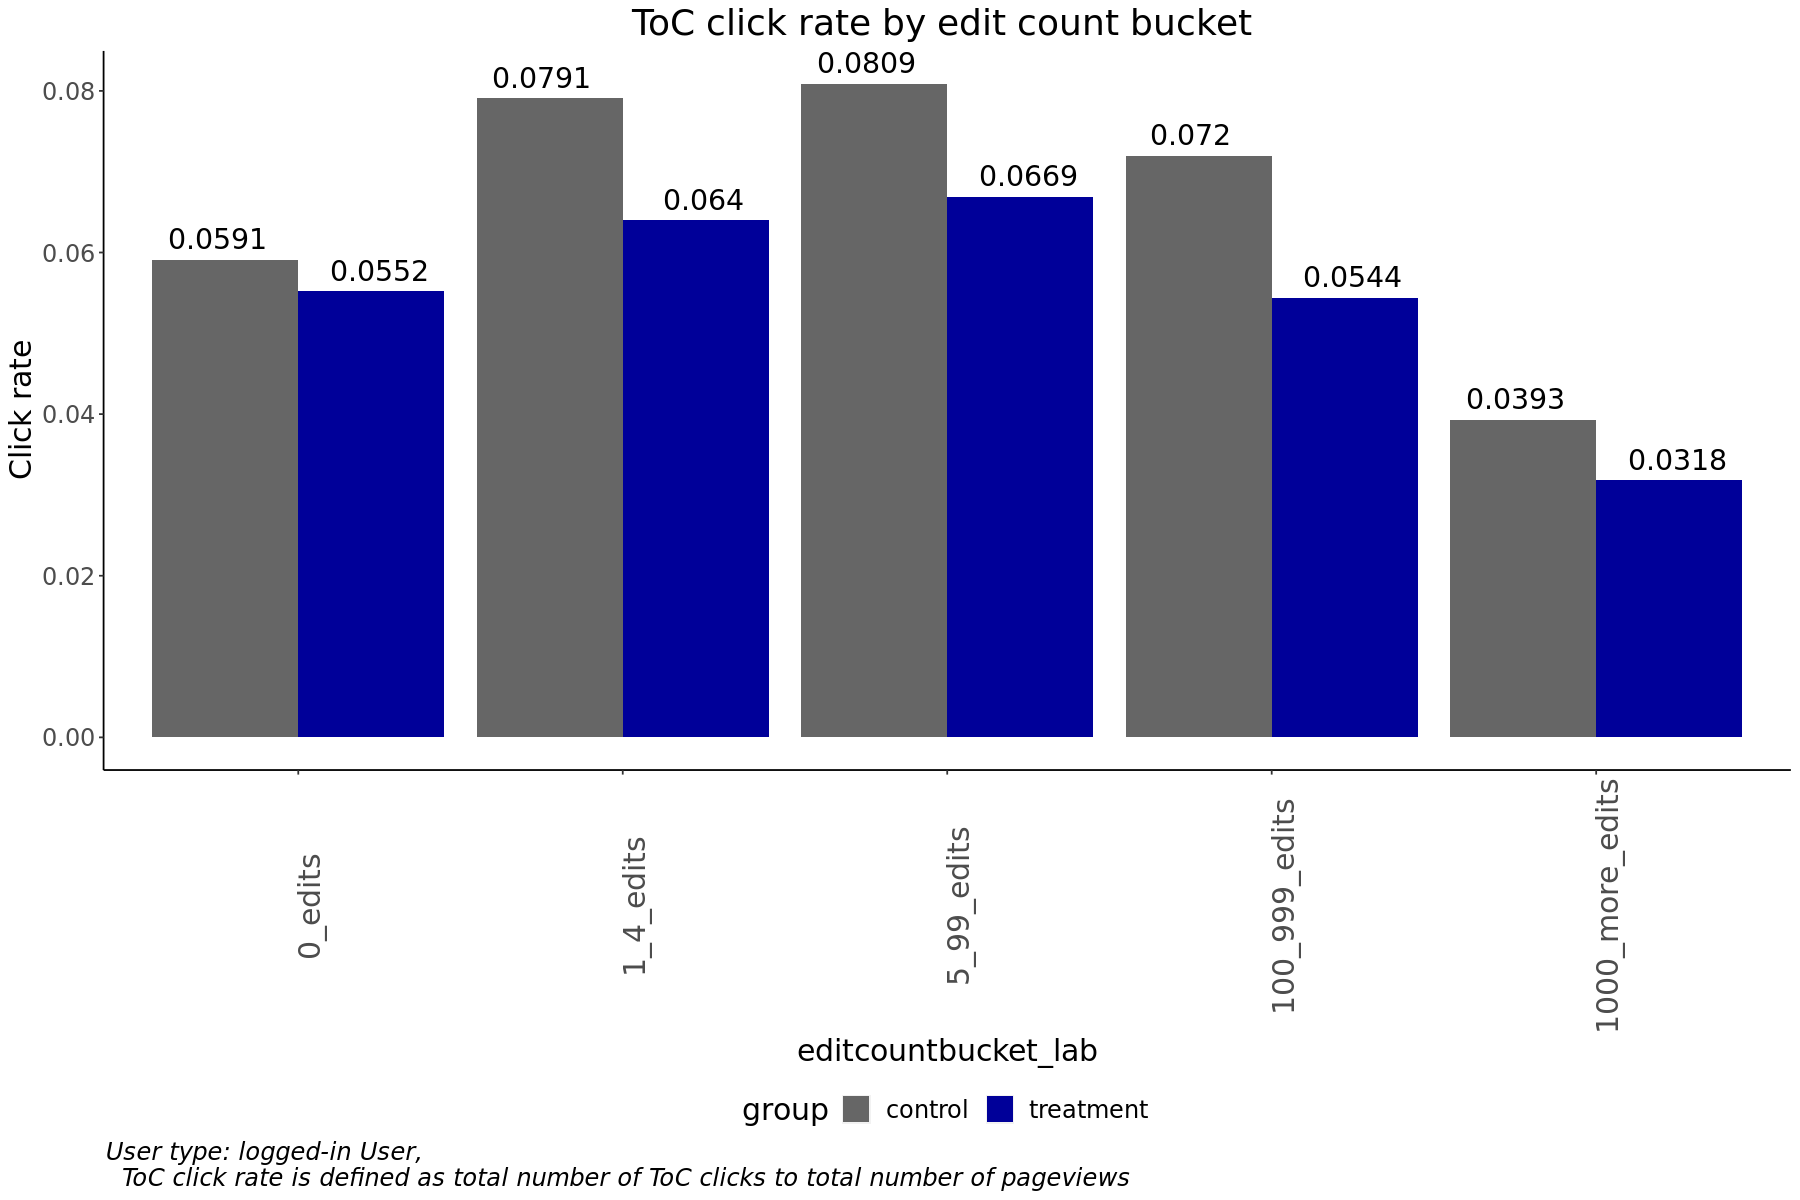

In [130]:
barchart_toc_click_rate_editcountbucket_overall  <- df_toc_click_editbucket_overall  %>%
        ggplot(aes(x = editcountbucket_lab, y= toc_click_per_pv, fill=test_group)) +
        geom_text(aes(label = paste(toc_click_per_pv)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.5, hjust = 0.5, size = 6) +
        geom_bar(stat="identity", position = 'dodge') +
        labs (
              y = "Click rate" ,
             title = "ToC click rate by edit count bucket " ,
             caption = "User type: logged-in User,
  ToC click rate is defined as total number of ToC clicks to total number of pageviews " ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_toc_click_rate_editcountbucket_overall

### Note
When broken down by the editor's experience levels, the decrease remains consistent across 4 edit count buckets except for 0 edit group.

# Dump file

In [31]:
write_csv(df_toc_pv_per_session, "Data/toc_pv_per_session_20230720.csv")